In [2]:
#import timm
import warnings 
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import pandas as pd
warnings.filterwarnings('ignore')
#set_seed(21, reproducible=True)

In [3]:
import torch
# Checking for GPU cuda and Device Optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(f'Using device: {device}')

Using device: cuda


In [11]:
train = pd.read_csv('train.csv')
train.head()

,image_id_worm,worm_type,number_of_worms
0,id_0002ea6f15c7fa6f4c221783.jpg,pbw,51
1,id_0005ef295aafe6acc63587db.jpg,pbw,8
2,id_00084298dd030a500033ff78.jpg,NaN,0
3,id_00093f2c76f6488737325859.jpg,pbw,12
4,id_000b2e6c437c643f25d4a6c3.jpg,pbw,87


In [6]:
train.shape

(9900, 3)

In [6]:
train.isnull().sum()

image_id_worm         0
worm_type          3258
number_of_worms       0
dtype: int64

In [8]:
train['worm_type'].value_counts()

pbw    4947
abw    1695
Name: worm_type, dtype: int64

### Train images distribution: 
* pbw    4947
* abw    1695
* Empty 3258

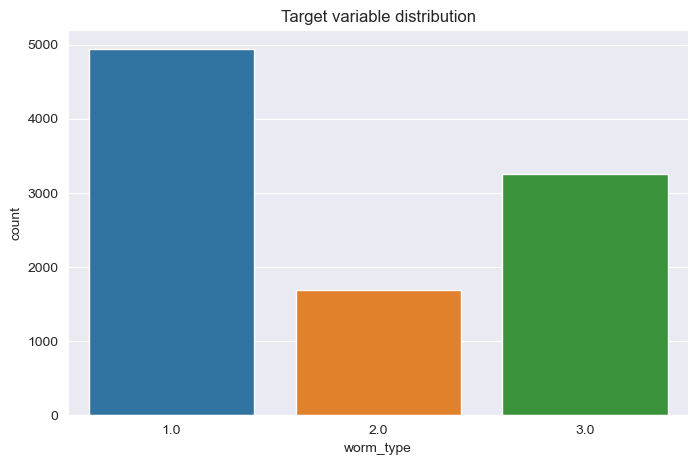

In [19]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(train['worm_type'])
plt.title('Target variable distribution')
plt.show()

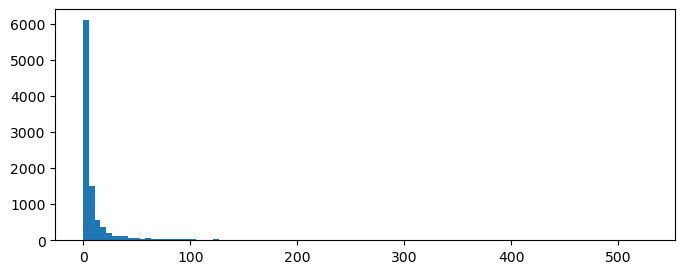

In [11]:
plt.figure(figsize=(8, 3))
plt.hist(train['number_of_worms'], bins=100)
plt.show()

In [12]:
print("max worms:", max(train['number_of_worms']))
print("min worms:", min(train['number_of_worms']))

max worms: 527
min worms: 0


In [13]:
train['number_of_worms'].value_counts()

0      3258
1       787
3       552
5       515
4       494
       ... 
229       1
527       1
135       1
166       1
241       1
Name: number_of_worms, Length: 244, dtype: int64

In [10]:
test = pd.read_csv('Test.csv')
test.head()

,image_id_worm
0,id_00332970f80fa9a47a39516d.jpg
1,id_0035981bc3ae42eb5b57a317.jpg
2,id_005102f664b820f778291dee.jpg
3,id_0066456f5fb2cd858c69ab39.jpg
4,id_007159c1fa015ba6f394deeb.jpg


In [10]:
test.shape

(2803, 1)

In [11]:
ss = pd.read_csv('SampleSubmission.csv')
ss

,image_id_worm,number_of_worms
0,id_00332970f80fa9a47a39516d_abw,0
1,id_00332970f80fa9a47a39516d_pbw,0
2,id_0035981bc3ae42eb5b57a317_abw,0
3,id_0035981bc3ae42eb5b57a317_pbw,0
4,id_005102f664b820f778291dee_abw,0
...,...,...
5601,id_ffbcb27fa549278f47505515_pbw,0
5602,id_ffc0e41e10b0c964d4a02811_abw,0
5603,id_ffc0e41e10b0c964d4a02811_pbw,0
5604,id_fff8c253115aacded09ad7ed_abw,0


## EDA of the Bounding Boxes

In [30]:
images_bboxes = pd.read_csv('images_bboxes.csv')
images_bboxes.head()

,image_id,worm_type,geometry
0,id_8ada71185e18dc8838b4925b.jpg,pbw,"POLYGON ((2478.89 156.77, 2478.89 297.86, 2377..."
1,id_8ada71185e18dc8838b4925b.jpg,pbw,"POLYGON ((939.8199999999999 1221.46, 939.81999..."
2,id_8ada71185e18dc8838b4925b.jpg,abw,"POLYGON ((1559.7 1558.06, 1559.7 1966.3, 1129...."
3,id_bc86d3cfd0c0463fa5cae33e.jpg,abw,POLYGON ((2090.216399557101 1537.2100674812148...
4,id_bc86d3cfd0c0463fa5cae33e.jpg,abw,POLYGON ((2342.2568587778546 1676.304250464547...


### Change the 'Geometry' column to make it suitable for training object detection 

In [31]:
def clean_geo_text(x):
    x=x.replace('POLYGON','')
    x=x.replace('((','')
    x=x.replace('))','')
    x =x.strip()
    x=x.split(',')
    return x

def split_XY(text):
    L=[]
    for x in text:
        x =x.strip()
        x=x.split(' ')
        L.append(x)
        np.array(L)
    return L
def add_XY(GeoListe):
    Xs=[L[0] for L in GeoListe]    
    Ys=[L[1] for L in GeoListe]

    return [max(Xs),min(Xs),max(Ys),min(Ys)]
    
images_bboxes['geometry']=images_bboxes['geometry'].astype(str)
images_bboxes['geometry']=images_bboxes['geometry'].apply(clean_geo_text)
images_bboxes['geometry']=images_bboxes['geometry'].apply(split_XY)
images_bboxes['geometry']=images_bboxes['geometry'].apply(add_XY)
images_bboxes[['max_X','min_X','max_Y','min_Y']] = pd.DataFrame(images_bboxes.geometry.tolist(), index= images_bboxes.index)
images_bboxes.to_csv('images_boxes.csv', index=False)

In [4]:
images_boxes = pd.read_csv('images_boxes.csv')
images_boxes.head()

,image_id,worm_type,min_X,min_Y,max_X,max_Y
0,id_8ada71185e18dc8838b4925b.jpg,1,2377.970000,156.770000,2478.890000,297.860000
1,id_8ada71185e18dc8838b4925b.jpg,1,715.390000,1221.460000,939.820000,1319.680000
2,id_8ada71185e18dc8838b4925b.jpg,2,1129.730000,1558.060000,1559.700000,1966.300000
3,id_bc86d3cfd0c0463fa5cae33e.jpg,2,1743.676282,1537.210067,2090.216400,1799.814857
4,id_bc86d3cfd0c0463fa5cae33e.jpg,2,2162.137567,1676.304250,2342.256859,1952.269926


### To get weight and height we use imagesize library *10 faster then getting the shape of image

In [5]:
import imagesize

def get_weight(x):
    width, height = imagesize.get("images/"+x)
    return width

images_boxes['weight']=images_boxes['image_id'].apply(get_weight)
def get_height(x):
    width, height = imagesize.get("images/"+x)
    return height
images_boxes['height']=images_boxes['image_id'].apply(get_height)

In [37]:
images_boxes

,image_id,worm_type,min_X,min_Y,max_X,max_Y,weight,height
0,id_8ada71185e18dc8838b4925b.jpg,1,2377.970000,156.770000,2478.890000,297.860000,3072,3072
1,id_8ada71185e18dc8838b4925b.jpg,1,715.390000,1221.460000,939.820000,1319.680000,3072,3072
2,id_8ada71185e18dc8838b4925b.jpg,2,1129.730000,1558.060000,1559.700000,1966.300000,3072,3072
3,id_bc86d3cfd0c0463fa5cae33e.jpg,2,1743.676282,1537.210067,2090.216400,1799.814857,4000,3000
4,id_bc86d3cfd0c0463fa5cae33e.jpg,2,2162.137567,1676.304250,2342.256859,1952.269926,4000,3000
...,...,...,...,...,...,...,...,...
136970,id_23617d0cdd8f04091b50106d.jpg,1,2177.440000,1777.340000,2221.630000,1835.630000,4160,3120
136971,id_23617d0cdd8f04091b50106d.jpg,1,2376.280000,1610.920000,2471.710000,1685.660000,4160,3120
136972,id_23617d0cdd8f04091b50106d.jpg,1,1732.730000,2174.090000,1819.700000,2248.830000,4160,3120
136973,id_23617d0cdd8f04091b50106d.jpg,1,1940.040000,2445.330000,2003.500000,2477.770000,4160,3120


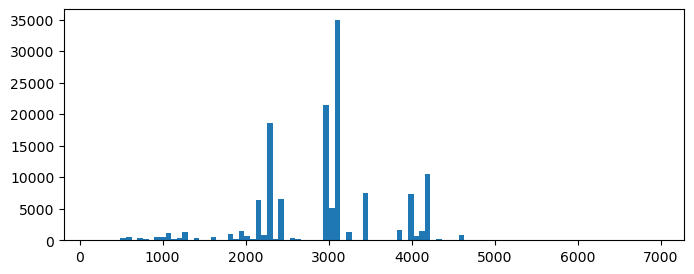

In [6]:
plt.figure(figsize=(8, 3))
plt.hist(images_boxes['height'], bins=100)
plt.show()

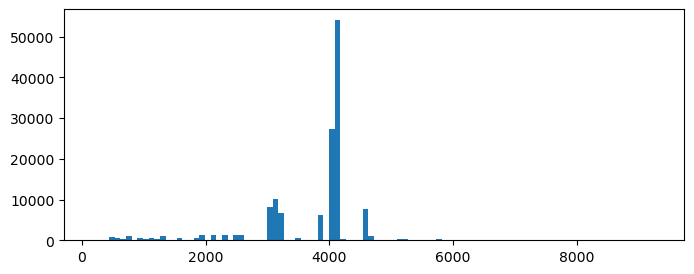

In [7]:
plt.figure(figsize=(8, 3))
plt.hist(images_boxes['weight'], bins=100)
plt.show()

### Resize 

In [ ]:
images_boxes['min_X'] = ( images_boxes['min_X'] / images_boxes['width'] ) * 500
images_boxes['min_Y'] = ( images_boxes['min_Y'] / images_boxes['height'] ) * 500
images_boxes['max_X'] = ( images_boxes['max_X'] / images_boxes['width'] ) * 500
images_boxes['max_Y'] = ( images_boxes['max_Y'] / images_boxes['height'] ) * 500

### Weight and height are really large we can't train models based on them so we have to resize to 500/500/3

In [ ]:
from PIL import Image
imgs = [image for image in train['image_id']] 
for x in imgs:
    image = Image.open('images/'+x)
    new_image = image.resize((500, 500))
    new_image.save('images_resized/'+x)

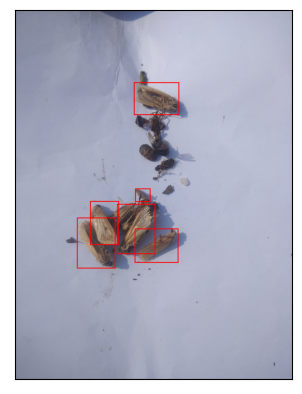

In [9]:
import torchvision.transforms.functional as F
from torchvision.io import read_image
import torch

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
img = read_image('images/id_f11b846c5dc0d9b877850584.jpg')
# creating boxes
boxes = torch.tensor(images_boxes[['min_X','min_Y','max_X','max_Y']][images_boxes['image_id'] == 'id_f11b846c5dc0d9b877850584.jpg'].values)

from torchvision.utils import draw_bounding_boxes

drawn_boxes = draw_bounding_boxes(img, boxes, colors="red", width=10)
show(drawn_boxes)